# 第四题
**使用scrapy框架爬取当当网计算机类书籍信息的首页。**

环境及依赖的安装此处省略，由于本说明是在WSL中使用jupyter编写，因此也不方便直接进行展示。接下来将以爬取当当首页的“新书上架”一栏资料为例，进行本人的作业展示。

### 1.创建项目：

In [1]:
!scrapy startproject DangDang_data

/usr/local/lib/python3.6/dist-packages/OpenSSL/_util.py:6: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.bindings.openssl.binding import Binding
New Scrapy project 'DangDang_data', using template directory '/usr/local/lib/python3.6/dist-packages/scrapy/templates/project', created in:
    /home/muiyu/code/introduction-of-data-science-2023/Chapter6/DangDang_data

You can start your first spider with:
    cd DangDang_data
    scrapy genspider example example.com


### 2.创建爬虫：

In [2]:
%cd DangDang_project
!scrapy genspider DangDang book.dangdang.com

/home/muiyu/code/introduction-of-data-science-2023/Chapter6/DangDang_data
/usr/local/lib/python3.6/dist-packages/OpenSSL/_util.py:6: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.bindings.openssl.binding import Binding
Created spider 'DangDang' using template 'basic' in module:
  DangDang_data.spiders.DangDang


创建了项目与爬虫后，我们得到一个爬虫项目框架，现在我们开始进行爬虫的编写。

### 3.通过xpath对网页数据进行筛选及爬取，以编写爬虫：

打开scrapy shell，通过调试来决定如何编写爬虫逻辑：

In [ ]:
!scrapy shell https://book.dangdang.com/01.54.htm #启动scrapy shell

在scrapy shell中输入以下代码，这将会打印这四个变量的值。通过在scrapy shell中不断调试，编写爬虫逻辑。

In [ ]:
new_book_price_sign = response.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="sign"]/text()').get()
new_book_price_num = response.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="num"]/text()').get()
new_book_price_tail = response.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="tail"]/text()').get()
new_book_price = f'{new_book_price_sign}{new_book_price_num}{new_book_price_tail}'


new_book_name = response.xpath('//ul[@class="product_ul"]/li/p[@class="name"]/a/text()').get()
new_book_author = response.xpath('//ul[@class="product_ul"]/li/p[@class="author"]/text()').get()
new_book_press_date = response.xpath('//ul[@class="product_ul"]/li/p[@class="press_date"]/text()').get()

new_book_name
new_book_author
new_book_press_date
new_book_price

jupyter中无法启用scrapy shell，这里我们使用API来展示效果：

In [7]:
from scrapy import Selector
import requests

url = 'https://book.dangdang.com/01.54.htm'
response = requests.get(url)
selector = Selector(response)

new_book_price_sign = selector.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="sign"]/text()').get()
new_book_price_num = selector.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="num"]/text()').get()
new_book_price_tail = selector.xpath('//ul[@class="product_ul"]/li/p[@class="price"]/span/span[@class="tail"]/text()').get()
new_book_price = f'{new_book_price_sign}{new_book_price_num}{new_book_price_tail}'


new_book_name = selector.xpath('//ul[@class="product_ul"]/li/p[@class="name"]/a/text()').get()
new_book_author = selector.xpath('//ul[@class="product_ul"]/li/p[@class="author"]/text()').get()
new_book_press_date = selector.xpath('//ul[@class="product_ul"]/li/p[@class="press_date"]/text()').get()

print("书名：",new_book_name)
print("作者：",new_book_author)
print("出版日期：",new_book_press_date)
print("现价：",new_book_price)

书名： Unity Shader入门与实战
作者： 黄志翔
出版日期： 2023-11-01
现价： ¥88.50


由此我们发现，xpath逻辑正确。由此编写一个爬虫(DangDang.py)：

In [ ]:
import scrapy

class DangdangSpider(scrapy.Spider):
    name = 'DangDangs'
    start_urls = ['https://book.dangdang.com/01.54.htm']

    def parse(self, response):
        for DangDang in response.xpath('//ul[@class="product_ul"]/li'):
            new_book_price_sign = DangDang.xpath('.//p[@class="price"]/span/span[@class="sign"]/text()').get()
            new_book_price_num = DangDang.xpath('.//p[@class="price"]/span/span[@class="num"]/text()').get()
            new_book_price_tail = DangDang.xpath('.//p[@class="price"]/span/span[@class="tail"]/text()').get()
            new_book_price = f'{new_book_price_sign}{new_book_price_num}{new_book_price_tail}'
            yield{
                "new_book_name" : DangDang.xpath('.//p[@class="name"]/a/text()').get(),
                "new_book_author" : DangDang.xpath('.//p[@class="author"]/text()').get(),
                "new_book_press_date" : DangDang.xpath('.//p[@class="press_date"]/text()').get(),
                "new_book_price" : new_book_price,
            }

### 4.通过pipelines对数据进行清洗并写入文件

我们在爬虫中使用`yield`将爬取的数据传输给了引擎，引擎会将这些数据传输给pipelines，因此我们需要在框架中的`pipelines.py`中对数据进行清洗与格式化。我个人编写的`pipelines.py`文件如下：

In [ ]:
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


# useful for handling different item types with a single interface
import json
import time

class DangdangDataPipeline:

    def open_spider(self, spider):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
        self.file = open(f'items_{timestamp}.jl', 'w', encoding='utf-8') #注意编码格式！网页爬取时，编码格式尤其重要。

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item), ensure_ascii=False) + "\n"
        self.file.write(line)
        return item

它只是简单地将我们得到的`Item`进行了json写入。

### 5.运行爬虫，得到数据集

In [10]:
%cd DangDang_project
!scrapy crawl DangDangs

[Errno 2] No such file or directory: 'DangDang_project'
/home/muiyu/code/introduction-of-data-science-2023/Chapter6/DangDang_data
/usr/local/lib/python3.6/dist-packages/OpenSSL/_util.py:6: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.bindings.openssl.binding import Binding
2023-11-15 01:37:58 [scrapy.utils.log] INFO: Scrapy 2.6.3 started (bot: DangDang_data)
2023-11-15 01:37:58 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.3, cssselect 1.1.0, parsel 1.6.0, w3lib 2.0.1, Twisted 22.4.0, Python 3.6.9 (default, Mar 10 2023, 16:46:00) - [GCC 8.4.0], pyOpenSSL 23.2.0 (OpenSSL 3.1.0 14 Mar 2023), cryptography 40.0.2, Platform Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-Ubuntu-18.04-bionic
2023-11-15 01:37:58 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'DangDan

### 6.数据集展示
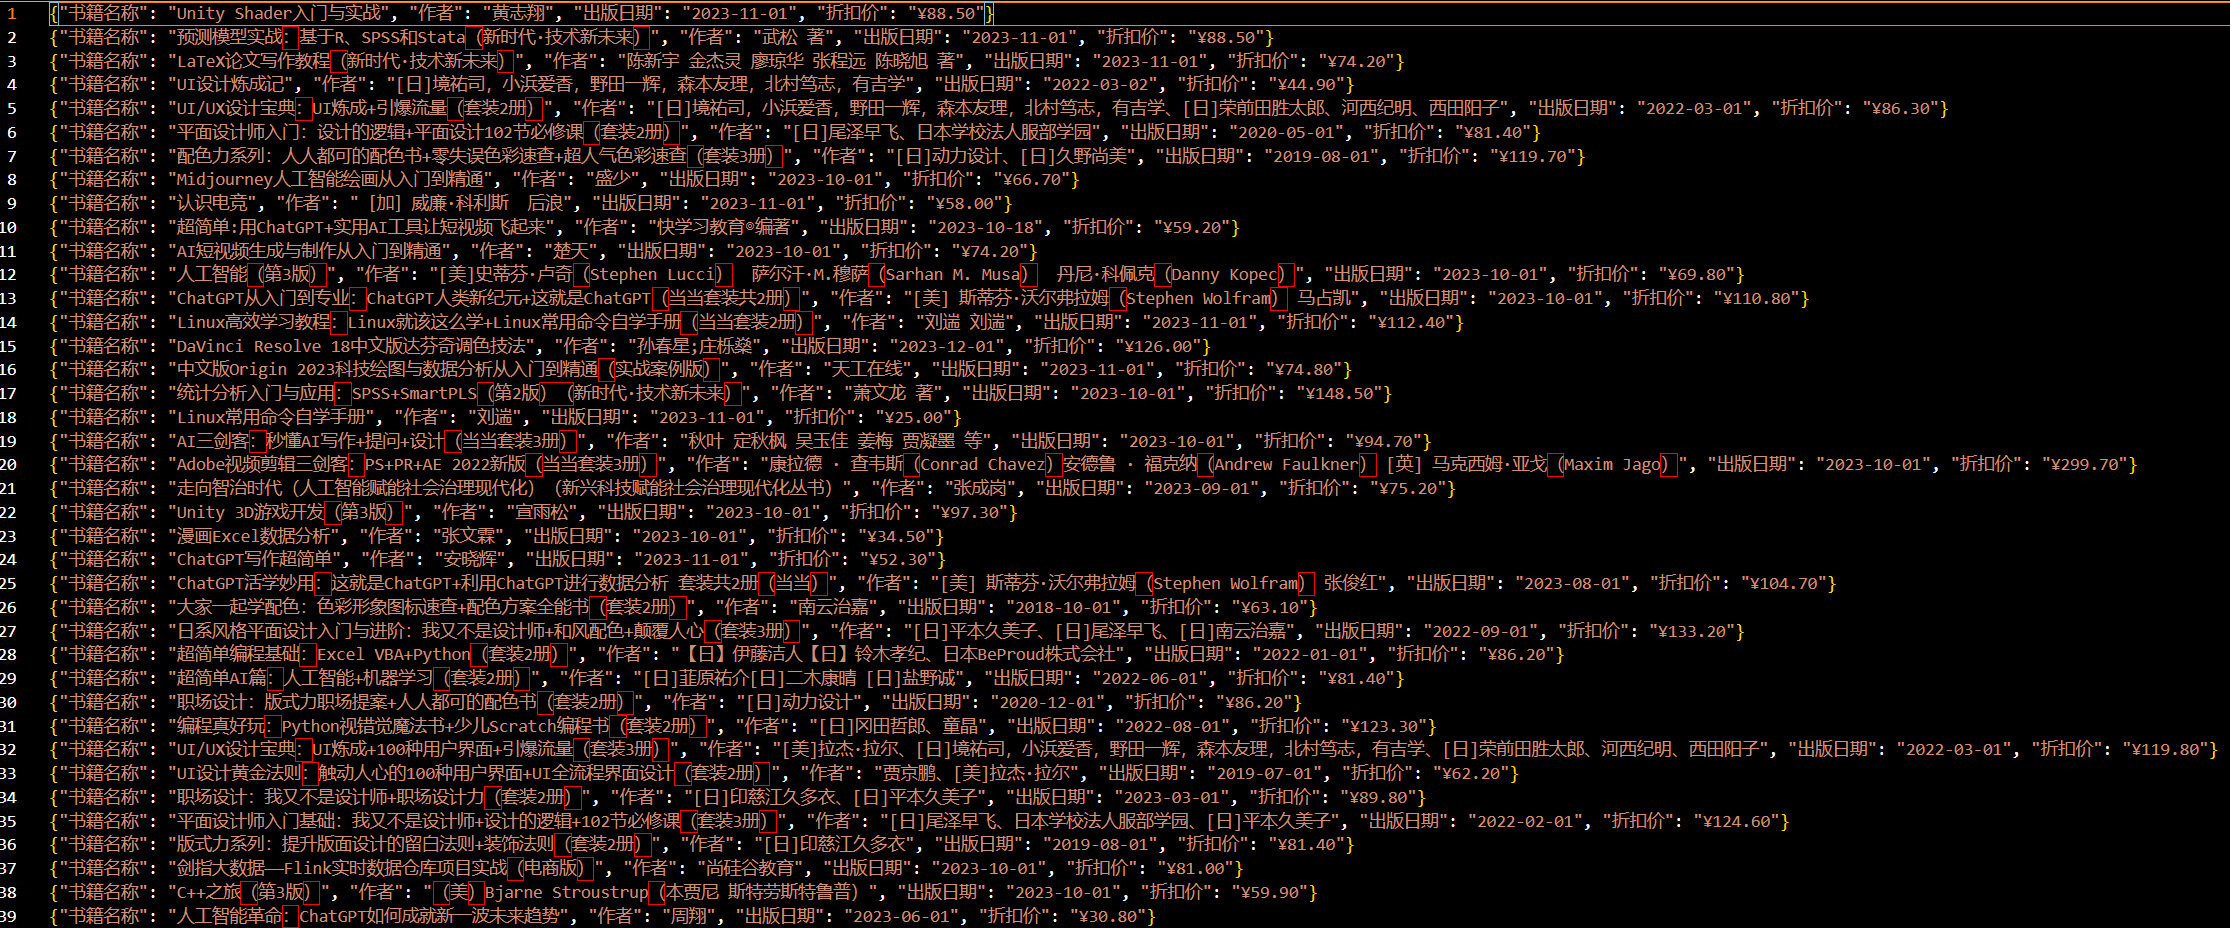

数据集见`items_2023-11-15-01-22-22.jl`